In [1]:
import pandas as pd

import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup

from datetime import datetime

import gspread

In [2]:
## Scrape
# Get the ChromeDriver path from your environment variable
chrome_driver_path = os.getenv('chrome_driver_path')
app_url = "https://finance.yahoo.com/quote/APP/holders/"

In [4]:
# Set up Chrome options for headless mode
options = Options()
options.add_argument('--headless') # Run in headless mode ('--headless=new')
options.add_argument("--window-size=1920,1080")  # Optional: set the window size for better layout handling
options.add_argument("--no-sandbox")  # Required for some environments
options.add_argument("--disable-dev-shm-usage")  # Optional: improve stability in headless mode

In [7]:
# Setup WebDriver
service = Service(chrome_driver_path)  # Use the path from environment variable
driver = webdriver.Chrome(service=service, options=options)

In [8]:
# Open the page
driver.get(app_url)

# Now proceed with your scraping task
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Close out
driver.quit()

In [9]:
## Dissect
# Locate the section containing the "Major Holders" table by the section's `data-testid` attribute
section = soup.find('section', {'data-testid': 'holders-major-holders-table'})
# Find all 'td' elements within the section to extract the data
td_elements = section.find_all('td', class_='majorHolders')

In [ ]:
"""
AttributeError: 'NoneType' object has no attribute 'text'
Job started at: Sun Mar  2 14:59:20 MST 2025
Traceback (most recent call last):
  File "/Users/ckopel/Github/app_yahoo/scripts/app_ownership_pull_load.py", line 74, in <module>
    stock_price = float(soup.find('span', {'data-testid': 'qsp-price'}).text.strip())
AttributeError: 'NoneType' object has no attribute 'text'
"""

<html class="desktop neo-green dock-upscale" data-color-scheme="auto" data-color-theme-enabled="true" lang="en-US" theme="auto"><head><script src="//pm-widget.taboola.com/yahooweb-network/load.js" type="text/javascript"></script>
<meta charset="utf-8"/>
<meta content="guce.yahoo.com" name="oath:guce:consent-host"/>
<link crossorigin="anonymous" href="//s.yimg.com" rel="preconnect"/><link href="//geo.yahoo.com" rel="preconnect"/><link href="//query1.finance.yahoo.com" rel="preconnect"/><link href="//query2.finance.yahoo.com" rel="preconnect"/><link href="//consent.cmp.oath.com" rel="preconnect"/><link as="worker" href="/__rapidworker-1.2.js" rel="preload"/><link href="https://s.yimg.com/uc/finance/webcore/js/_staticFinProtobuf.4b1559b8e4645fd93a12.js" rel="preconnect"/><link href="https://cdn.jsdelivr.net/npm/protobufjs@7.1.2/dist/minimal/protobuf.min.js" rel="preconnect"/><script>window.finNeoPageStart = Date.now();</script><script>(function(){if(!window.YAHOO){window.YAHOO={}}; window
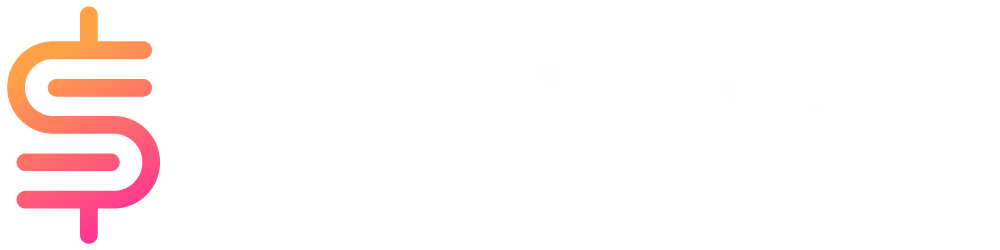

In [11]:
soup

In [18]:
## Load dict
# Initialize an empty dictionary
holders_dict = {}

# Iterate through the list in pairs (numeric value and its corresponding label)
for i in range(0, len(td_elements), 2):
    # Strip any extra characters and clean up the value
    value = td_elements[i].text.strip().replace('%', '').replace(',','')
    
    # Convert the value to float or integer as appropriate
    if '.' in value:
        value = float(value)
    else:
        value = int(value)
    
    # Get the corresponding key (label)
    label = td_elements[i+1].text.strip()
    
    # Update the dictionary
    holders_dict[label] = value

## Stock Price
# Look for the `fin-streamer` tag with both `data-field="regularMarketPrice"` and `data-symbol="APP"`
price_element = soup.find('fin-streamer', {'data-field': 'regularMarketPrice', 'data-symbol': 'APP'}) # changed 2025-01-12 # changed 2025-01-12 # changed back on 2025-03-02 (below stopped working but this worked again)
# # Extract the value from the 'data-value' attribute
stock_price = float(price_element['data-value']) # changed 2025-01-12 # changed back on 2025-03-02 (below stopped working but this worked again)

# stock_price = float(soup.find('span', {'data-testid': 'qsp-price'}).text.strip()) # reverted to the above on 2025-03-02 (this stopped working but the above worked again)

# Extract the values in the correct order (A, B, C, D, E, F)
values = [
    stock_price,
    holders_dict["% of Shares Held by All Insider"],
    holders_dict["% of Shares Held by Institutions"],
    holders_dict["% of Float Held by Institutions"],
    holders_dict["Number of Institutions Holding Shares"],
    datetime.now().strftime("%Y/%m/%d %H:%M:%S") + " MT"
]


In [16]:
### Send to GSheet
## Config details
sa_path_windows = r"C:\Users\Owner\AppData\Local\Programs\Python\Python310\Lib\site-packages\gspread\service_account.json"
sa_path_mac = "/Users/ckopel/Documents/keys/service_account.json"
sa_path = sa_path_windows if os.name == "nt" else sa_path_mac if os.name == "posix" else None

gc = gspread.service_account(filename=sa_path)


## Open the sheet
sh = gc.open("APP Ownership")
worksheet = sh.worksheet("Data")  # Access the "Data" sheet


# Insert a new row at position 2 (shifts existing row 2 and below down)
worksheet.insert_row([], 2)

# Update row 2 with the new data in columns A to F
worksheet.update([values], 'A2:F2')

# Add formulas individually to columns F:I for the new row using update_acell (all together came through as a string in the gsheet)
worksheet.update_acell('G2', '=IFERROR(((A2-A3)/A3),"")')
worksheet.update_acell('H2', '=IFERROR(((B2-B3)/B3),"")')
worksheet.update_acell('I2', '=IFERROR(((C2-C3)/C3),"")')
worksheet.update_acell('J2', '=IFERROR(((D2-D3)/D3),"")')
worksheet.update_acell('K2', '=IFERROR(((E2-E3)/E3),"")')

{'spreadsheetId': '1WLCqIuF9P7_ypl_hF-9QtwaFr2-jjl0DDNgpB9HfB7A',
 'updatedRange': 'Data!K2',
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}